## Heart failure prediction based on the MIMIC-III dataset
This notebook provides a basic code to preprocess the MIMIC-III dataset and two multi-layer perceptron (MLP) models for heart failure (HF) prediction.
In this version, only the DIAGNOSIS table was used, to avoid sparsity. The goal of the model is to predict the incidence of HF in the next visit, given the observed ICD-9 codes for a certain patient.

In [1]:
""" # if using google drive, mounting drive for mimic-iii access
from google.colab import drive
drive.mount('/content/drive') """

" # if using google drive, mounting drive for mimic-iii access\nfrom google.colab import drive\ndrive.mount('/content/drive') "

In [2]:
import pandas as pd

# add the path to the files
# if they are in your google drive, it will look something like this:
# /content/drive/MyDrive/Colab Notebooks/mimic-iii-demo/ADMISSIONS.csv

diagnoses_path = "data\mimic-iii\DIAGNOSES_ICD.csv"

# loading data
diagnoses = pd.read_csv(diagnoses_path)

In [65]:
print("\nDiagnoses table, containing data about patients' diagnoses based on ICD codes:")
# diagnoses.head()


Diagnoses table, containing data about patients' diagnoses based on ICD codes:


In [4]:
unique_subject_ids_count = diagnoses['SUBJECT_ID'].nunique()
print(f"Total number of patients: {unique_subject_ids_count}")

Total number of patients: 46520


In [5]:
unique_icd9_count = diagnoses['ICD9_CODE'].nunique()
print(f"Total number of unique ICD-9 codes: {unique_icd9_count}")

Total number of unique ICD-9 codes: 6984


In [77]:
""" import matplotlib.pyplot as plt
import seaborn as sns

icd9_counts = diagnoses['ICD9_CODE'].value_counts()
top_icd9_counts = icd9_counts.head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_icd9_counts.index, y=top_icd9_counts.values)
plt.ylabel('Count')
plt.xlabel('ICD-9 codes')
plt.title('10 Most Frequent ICD-9 Codes in the MIMIC-III dataset')

# adding code counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show() """

" import matplotlib.pyplot as plt\nimport seaborn as sns\n\nicd9_counts = diagnoses['ICD9_CODE'].value_counts()\ntop_icd9_counts = icd9_counts.head(10)\n\nplt.figure(figsize=(10, 6))\nax = sns.barplot(x=top_icd9_counts.index, y=top_icd9_counts.values)\nplt.ylabel('Count')\nplt.xlabel('ICD-9 codes')\nplt.title('10 Most Frequent ICD-9 Codes in the MIMIC-III dataset')\n\n# adding code counts\nfor p in ax.patches:\n    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), \n                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), \n                textcoords='offset points')\n\nplt.tight_layout()\nplt.show() "

In [7]:
# avg no. of icd-9 codes assigned to a subject
avg_icd_per_subject = diagnoses.groupby('SUBJECT_ID')['ICD9_CODE'].nunique().mean()

# avg visits per subject
avg_visits_per_subject = diagnoses.groupby('SUBJECT_ID')['HADM_ID'].nunique().mean()

# subjects with less than 2 visits
subjects_less_than_2_visits = (diagnoses.groupby('SUBJECT_ID')['HADM_ID'].nunique() < 2).sum()

# subjects with more than 2 visits
subjects_more_than_2_visits = (diagnoses.groupby('SUBJECT_ID')['HADM_ID'].nunique() >= 2).sum()

print(f"Average number of ICD codes per subject: {avg_icd_per_subject}")
print(f"Average number of visits per patient: {avg_visits_per_subject}")
print(f"Number of patients with less than 2 visits: {subjects_less_than_2_visits}")
print(f"Number of patients with more than 2 visits: {subjects_more_than_2_visits}")

Average number of ICD codes per subject: 12.615477214101462
Average number of visits per patient: 1.267755803955288
Number of patients with less than 2 visits: 38983
Number of patients with more than 2 visits: 7537


In [8]:
diagnoses.shape

(651047, 5)

In [66]:
# first, remove patients with less than 2 visits
diagnoses = diagnoses.groupby('SUBJECT_ID').filter(lambda x: x['HADM_ID'].nunique() >= 2)
# diagnoses.head()

In [10]:
# each row indicates an icd code entry given a patient's visit
diagnoses.shape

(260326, 5)

In [11]:
filtered_diagnoses = diagnoses.groupby('SUBJECT_ID').filter(lambda x: len(x['HADM_ID']) >= 2)
unique_patients_with_multiple_visits = filtered_diagnoses['SUBJECT_ID'].nunique()

unique_patients = diagnoses['SUBJECT_ID'].nunique()

print(f"Number of unique patients with 2+ visits: {unique_patients_with_multiple_visits}")
print(f"Total number of unique patients: {unique_patients}")

Number of unique patients with 2+ visits: 7537
Total number of unique patients: 7537


In [67]:
# for diagnosis, hospital admission id, and icd-9 codes
# goal: diagnose HF at a patient level
diags = diagnoses[['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']]
# print(diags.head())
print("\nMissing values in selected Diagnoses:")
print(diags.isnull().sum())


Missing values in selected Diagnoses:
SUBJECT_ID     0
HADM_ID        0
SEQ_NUM       44
ICD9_CODE     44
dtype: int64


In [68]:
# dropping rows (patients) with missing values
diags = diags.dropna(subset=['SEQ_NUM', 'ICD9_CODE'])
# print(diags.head())
print("\nMissing values in cleaned Diagnoses:")
print(diags.isnull().sum())


Missing values in cleaned Diagnoses:
SUBJECT_ID    0
HADM_ID       0
SEQ_NUM       0
ICD9_CODE     0
dtype: int64


In [15]:
diagnoses.shape

(260326, 5)

In [16]:
# heart failure diagnosis for binary label
hf_icd9_codes = ['4250', '4251', '4252', '4253', '4254', '4255', '4257', '4258', '4259', '42983',
                 '42830', '42832', '42840', '42842',
                 '39891', '4280', '4281', '42820', '42822', '4289',
                 '40211', '40291',
                 '40411', '40491',
                 '4168', '4169'
                 ]

In [17]:
# counting heart failure cases
diags = diagnoses[['ICD9_CODE', 'SUBJECT_ID', 'SEQ_NUM']].copy()
diags['heart_failure'] = diags['ICD9_CODE'].isin(hf_icd9_codes).astype(int)
diags.head()

heart_failure_frequencies = diags['heart_failure'].value_counts()
print(f"\nFrequencies of heart failure (1 = prevalence in an encounter; 0 = non-prevalence):\n{heart_failure_frequencies})")


Frequencies of heart failure (1 = prevalence in an encounter; 0 = non-prevalence):
heart_failure
0    248961
1     11365
Name: count, dtype: int64)


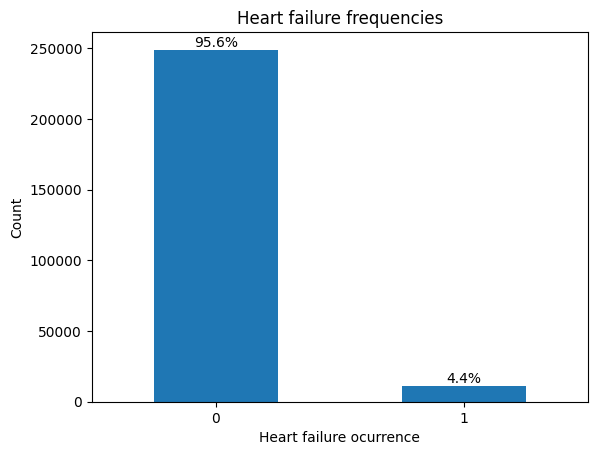

In [18]:
# visualizing the classes

# hf percentages in dataset
total = sum(heart_failure_frequencies)
percentages = (heart_failure_frequencies / total) * 100

# hf value counts
ax = heart_failure_frequencies.plot(kind='bar')
plt.title('Heart failure frequencies')
plt.xlabel('Heart failure ocurrence')
plt.ylabel('Count')
plt.xticks(rotation=0)

# annotating bars
for idx, rect in enumerate(ax.patches):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height + 5,
            '{:.1f}%'.format(percentages[idx]),
            ha='center', va='bottom', color='black')

plt.show()

The goal now is to create sequence of visits for each patient.
Given the patient trajectory, if a certain visit has a heart failure (HF) code:  

    - Remove that specific visit and the subsequent ones;
    - Label the patient as HF = 1;
    - Else, label the patient as HF = 0.

In [78]:
# diagnoses.head()

In [20]:
diagnoses.shape

(260326, 5)

In [69]:
# sort diagnoses by SUBJECT_ID and SEQ_NUM (patients visits in chronological order)
sorted_df = diagnoses.copy().sort_values(by=['SUBJECT_ID', 'HADM_ID'])
# sorted_df.head()

In [22]:
icd9_code_type = type(sorted_df['ICD9_CODE'].iloc[0])
print(f"The data type of the 'ICD9_CODE' column is: {icd9_code_type}")

The data type of the 'ICD9_CODE' column is: <class 'str'>


In [23]:
# create sequences of visits for each patient
patient_sequences = {}

for _, row in sorted_df.iterrows():
    patient_id = row['SUBJECT_ID']
    visit_id = row['HADM_ID']
    
    if patient_id not in patient_sequences:
        patient_sequences[patient_id] = {}
    if visit_id not in patient_sequences[patient_id]:
        patient_sequences[patient_id][visit_id] = []
    
    patient_sequences[patient_id][visit_id].append(row.to_dict())


In [79]:
""" first_2_sequences = dict(list(patient_sequences.items())[:2])

# visualizing the first 2 patient sequences
for patient_id, visits in list(patient_sequences.items())[:5]:
    print(f"Patient ID: {patient_id}")
    for visit_id, codes in visits.items():
        print(f"Visit ID: {visit_id}")
        for code in codes:
            print(code)
        print("\n")
    print("-"*50 + "\n") """

' first_2_sequences = dict(list(patient_sequences.items())[:2])\n\n# visualizing the first 2 patient sequences\nfor patient_id, visits in list(patient_sequences.items())[:5]:\n    print(f"Patient ID: {patient_id}")\n    for visit_id, codes in visits.items():\n        print(f"Visit ID: {visit_id}")\n        for code in codes:\n            print(code)\n        print("\n")\n    print("-"*50 + "\n") '

In [80]:
hf_labels = {}

# iterating over each patient's sequence of visits
for patient_id, visits in list(patient_sequences.items()): 
    hf_detected = False
    visits_to_remove = []
    first_visit_id = min(visits.keys())

    # checking if HF code exists in the first visit
    for code in visits[first_visit_id]:
        if code['ICD9_CODE'] in hf_icd9_codes:
            hf_detected = True
            del patient_sequences[patient_id]  # remove the patient entirely from the sequences
            break

    # if HF code is found in the first visit, skip the remaining checks for this patient and do not assign a label
    if hf_detected:
        continue

    # checking the other visits for the HF codes
    for visit_id, codes in visits.items():
        if hf_detected:  # if HF was detected in a previous visit, mark all subsequent visits for removal
            visits_to_remove.append(visit_id)
            continue  # skip the current visit

        for code in codes:
            if code['ICD9_CODE'] in hf_icd9_codes:
                hf_detected = True
                visits_to_remove.append(visit_id)
                break  # once HF code is detected, stop checking other codes in the current visit

    # remove visits marked for deletion
    for vid in visits_to_remove:
        del visits[vid]

    # assign HF label to a patient based on detection
    hf_labels[patient_id] = 1 if hf_detected else 0


In [71]:
""" # visualizing the updated patient sequences and HF labels for the first 2 patients
for patient_id, visits in list(patient_sequences.items())[:2]:
    print(f"Patient ID: {patient_id}, HF Label: {hf_labels[patient_id]}")
    for visit_id, codes in visits.items():
        print(f"Visit ID: {visit_id}")
        for code in codes:
            print(code)
        print("\n")
    print("-"*50 + "\n") """

' # visualizing the updated patient sequences and HF labels for the first 2 patients\nfor patient_id, visits in list(patient_sequences.items())[:2]:\n    print(f"Patient ID: {patient_id}, HF Label: {hf_labels[patient_id]}")\n    for visit_id, codes in visits.items():\n        print(f"Visit ID: {visit_id}")\n        for code in codes:\n            print(code)\n        print("\n")\n    print("-"*50 + "\n") '

In [72]:
""" # get patient IDs with HF label = 1
patients_with_hf = [patient_id for patient_id, label in hf_labels.items() if label == 1]

# visualizing the sequences for the first 2 patients with HF label = 1
for patient_id in patients_with_hf[:2]:
    visits = patient_sequences[patient_id]
    print(f"Patient ID: {patient_id}, HF Label: {hf_labels[patient_id]}")
    for visit_id, codes in visits.items():
        print(f"Visit ID: {visit_id}")
        for code in codes:
            print(code)
        print("\n")
    print("-"*50 + "\n")
 """

' # get patient IDs with HF label = 1\npatients_with_hf = [patient_id for patient_id, label in hf_labels.items() if label == 1]\n\n# visualizing the sequences for the first 2 patients with HF label = 1\nfor patient_id in patients_with_hf[:2]:\n    visits = patient_sequences[patient_id]\n    print(f"Patient ID: {patient_id}, HF Label: {hf_labels[patient_id]}")\n    for visit_id, codes in visits.items():\n        print(f"Visit ID: {visit_id}")\n        for code in codes:\n            print(code)\n        print("\n")\n    print("-"*50 + "\n")\n '

In [28]:
from collections import Counter

# count the labels
label_counts = Counter(hf_labels.values())
count_label_1 = label_counts[1]
count_label_0 = label_counts[0]

print(f"Number of patients with label 1 (HF): {count_label_1}")
print(f"Number of patients with label 0 (No HF): {count_label_0}")


Number of patients with label 1 (HF): 980
Number of patients with label 0 (No HF): 3896


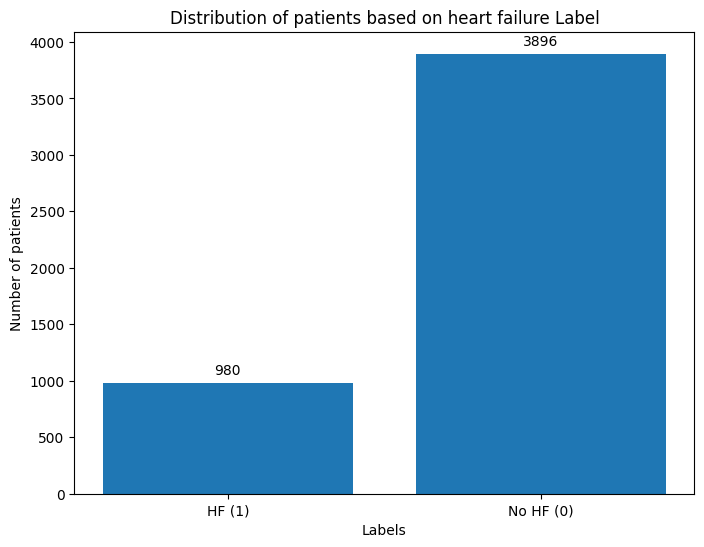

In [81]:
# plotting the hf frequencies
labels = ['HF (1)', 'No HF (0)']
counts = [count_label_1, count_label_0]

plt.figure(figsize=(8,6))
bars = plt.bar(labels, counts)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, str(height), ha='center', va='bottom')

plt.xlabel('Labels')
plt.ylabel('Number of patients')
plt.title('Distribution of patients based on heart failure Label')
plt.show()


In [82]:
# flatten the patient_sequences
flattened_data = []

for patient_id, visits in patient_sequences.items():
    for visit_id, codes in visits.items():
        # extracting icd codes for the visit
        icd9_codes_for_visit = [code['ICD9_CODE'] for code in codes]
        
        flattened_data.append({
            'patient_id': patient_id,
            'visit_id': visit_id,
            'icd9_codes': icd9_codes_for_visit,
            'label': hf_labels[patient_id]
        })

# convert the list of dictionaries into a df
flattened_df = pd.DataFrame(flattened_data)
# flattened_df.head()


In [74]:
# expanding df
expanded_df = flattened_df.explode('icd9_codes').reset_index(drop=True)

# truncating ICD9 codes to first 4 characters
expanded_df['icd9_codes'] = expanded_df['icd9_codes'].str[:4]
# expanded_df.head()

In [83]:
# one-hot encoding the truncated icd codes
encoded_icd9 = pd.get_dummies(expanded_df['icd9_codes'])

# joining the encoded icd dataframe with the expanded dataframe
final_df = expanded_df.join(encoded_icd9)

# drop the icd9_codes column
final_df = final_df.drop(['icd9_codes'], axis=1)
final_df = final_df * 1

# final_df.head()

In [33]:
import torch

# pos_weight for optional use in loss
hf_label_counts = final_df['label'].value_counts()
non_hf_frequency = hf_label_counts[0]
hf_frequency = hf_label_counts[1]

pos_weight = torch.tensor([non_hf_frequency / hf_frequency], dtype=torch.float32)
print("pos_weight:", pos_weight.item())


pos_weight: 6.818854808807373


In [34]:
from sklearn.model_selection import train_test_split
X = final_df.drop(columns=['label'])
y = final_df['label']

In [35]:
len(X), len(y) # no. samples

(120426, 120426)

In [76]:
""" print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of Y: {y[:5]}") """

' print(f"First 5 samples of X: {X[:5]}")\nprint(f"First 5 samples of Y: {y[:5]}") '

In [37]:
num_features = X.shape[1]
print(f"Number of features in X: {num_features}")

Number of features in X: 2773


In [38]:
X.shape, y.shape

((120426, 2773), (120426,))

In [39]:
import torch
torch.__version__

'2.0.1+cpu'

In [40]:
""" print(type(X), X.dtype)
print(type(y), X.dtype)
 """

' print(type(X), X.dtype)\nprint(type(y), X.dtype)\n '

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [42]:
len(X_train), len(X_test), len(y_train), len(y_test)


(96340, 24086, 96340, 24086)

## Training

In [43]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # extra dim for the label

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)  # extra dim for the label


In [44]:
# creating custom dataset
from torch.utils.data import Dataset, DataLoader

class MIMICDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [45]:
# creating data loaders
BATCH_SIZE = 32  

train_dataset = MIMICDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MIMICDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape # 32 batches with 2773 features; 32 batches with 1 feature (label)

(torch.Size([32, 2773]), torch.Size([32, 1]))

In [47]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [48]:
class MLP_MIMIC_V0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_stack = nn.Sequential(
    nn.Linear(in_features=2773, out_features=246),
    nn.ReLU(),
    nn.Linear(in_features=246, out_features=246),
    nn.ReLU(),
    nn.Linear(in_features=246, out_features=1))

  def forward(self, x):
    return self.layer_stack(x)

model_0 = MLP_MIMIC_V0().to(device)

In [49]:
""" model_0.state_dict()
 """

' model_0.state_dict()\n '

In [50]:
loss_fn = nn.BCEWithLogitsLoss() # binary cross entropy loss with built in sigmoid; pos_weight=pos_weight use is optional

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

In [51]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [52]:
model_0

MLP_MIMIC_V0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2773, out_features=246, bias=True)
    (1): ReLU()
    (2): Linear(in_features=246, out_features=246, bias=True)
    (3): ReLU()
    (4): Linear(in_features=246, out_features=1, bias=True)
  )
)

In [53]:
# training loop for model_0
torch.manual_seed(22)
torch.cuda.manual_seed(22)
model_0.to(device)

# for tracking model progress
epoch_count_0 = []
train_loss_values_0 = []
train_acc_values_0 = []
test_loss_values_0 = []
test_acc_values_0 = []

# epochs
epochs = 10

for epoch in range(epochs):
    model_0.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    
    # train loop w dataloaders
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        y_logits = model_0(batch_X).squeeze(1)
        batch_y = batch_y.squeeze(1)
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        train_loss = loss_fn(y_logits, batch_y)
        train_acc = accuracy_fn(y_true=batch_y, y_pred=y_pred)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        running_train_loss += train_loss
        running_train_acc += train_acc
    
    # avg out the loss and accuracy over the entire dataset
    average_train_loss = running_train_loss / len(train_loader)
    average_train_acc = running_train_acc / len(train_loader)

    # test loop w dataloaders
    model_0.eval()
    running_test_loss = 0.0
    running_test_acc = 0.0
    
    with torch.inference_mode():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            test_logits = model_0(batch_X).squeeze(1)
            batch_y = batch_y.squeeze(1)
            test_pred = torch.round(torch.sigmoid(test_logits))
            
            test_loss = loss_fn(test_logits, batch_y)
            test_acc = accuracy_fn(y_true=batch_y, y_pred=test_pred)
            
            running_test_loss += test_loss
            running_test_acc += test_acc
    
    average_test_loss = running_test_loss / len(test_loader)
    average_test_acc = running_test_acc / len(test_loader)

    epoch_count_0.append(epoch)
    train_loss_values_0.append(average_train_loss)
    train_acc_values_0.append(average_train_acc)
    test_loss_values_0.append(average_test_loss)
    test_acc_values_0.append(average_test_acc)

    print(f"Epoch: {epoch + 1} | Train loss: {average_train_loss:.3f} | Train acc: {average_train_acc:.3f} | Test loss: {average_test_loss:.3f} | Test acc: {average_test_acc:.3f}")


Epoch: 1 | Train loss: 3.842 | Train acc: 87.037 | Test loss: 0.382 | Test acc: 87.322
Epoch: 2 | Train loss: 0.384 | Train acc: 87.181 | Test loss: 0.381 | Test acc: 87.322
Epoch: 3 | Train loss: 0.384 | Train acc: 87.182 | Test loss: 0.380 | Test acc: 87.322
Epoch: 4 | Train loss: 0.384 | Train acc: 87.182 | Test loss: 0.380 | Test acc: 87.322
Epoch: 5 | Train loss: 0.384 | Train acc: 87.180 | Test loss: 0.381 | Test acc: 87.322
Epoch: 6 | Train loss: 0.383 | Train acc: 87.182 | Test loss: 0.380 | Test acc: 87.322
Epoch: 7 | Train loss: 0.383 | Train acc: 87.182 | Test loss: 0.380 | Test acc: 87.322
Epoch: 8 | Train loss: 0.383 | Train acc: 87.180 | Test loss: 0.380 | Test acc: 87.322
Epoch: 9 | Train loss: 0.383 | Train acc: 87.183 | Test loss: 0.380 | Test acc: 87.322
Epoch: 10 | Train loss: 0.383 | Train acc: 87.182 | Test loss: 0.380 | Test acc: 87.322


In [54]:
class MLP_MIMIC_V1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2773, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=256, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x):
        return self.layer_stack(x)

model_1 = MLP_MIMIC_V1().to(device)


In [64]:
model_1

MLP_MIMIC_V1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2773, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [55]:
loss_fn = nn.BCEWithLogitsLoss() # binary cross entropy loss with built in sigmoid
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

# training loop for model_1
torch.manual_seed(22)
torch.cuda.manual_seed(22)
model_1.to(device)

# for tracking model progress
epoch_count_1 = []
train_loss_values_1 = []
train_acc_values_1 = []
test_loss_values_1 = []
test_acc_values_1 = []

# epochs
epochs = 10

for epoch in range(epochs):
    model_1.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    
    # train loop w dataloaders
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        y_logits = model_1(batch_X).squeeze(1)
        batch_y = batch_y.squeeze(1)
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        train_loss = loss_fn(y_logits, batch_y)
        train_acc = accuracy_fn(y_true=batch_y, y_pred=y_pred)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        running_train_loss += train_loss
        running_train_acc += train_acc
    
    # avg out the loss and accuracy over the entire dataset
    average_train_loss = running_train_loss / len(train_loader)
    average_train_acc = running_train_acc / len(train_loader)

    # test loop w dataloaders
    model_1.eval()
    running_test_loss = 0.0
    running_test_acc = 0.0
    
    with torch.inference_mode():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            test_logits = model_1(batch_X).squeeze(1)
            batch_y = batch_y.squeeze(1)
            test_pred = torch.round(torch.sigmoid(test_logits))
            
            test_loss = loss_fn(test_logits, batch_y)
            test_acc = accuracy_fn(y_true=batch_y, y_pred=test_pred)
            
            running_test_loss += test_loss
            running_test_acc += test_acc
    
    average_test_loss = running_test_loss / len(test_loader)
    average_test_acc = running_test_acc / len(test_loader)

    epoch_count_1.append(epoch)
    train_loss_values_1.append(average_train_loss)
    train_acc_values_1.append(average_train_acc)
    test_loss_values_1.append(average_test_loss)
    test_acc_values_1.append(average_test_acc)

    print(f"Epoch: {epoch + 1} | Train loss: {average_train_loss:.3f} | Train acc: {average_train_acc:.3f} | Test loss: {average_test_loss:.3f} | Test acc: {average_test_acc:.3f}")


Epoch: 1 | Train loss: 0.365 | Train acc: 87.148 | Test loss: 0.353 | Test acc: 87.322
Epoch: 2 | Train loss: 0.361 | Train acc: 87.166 | Test loss: 0.354 | Test acc: 87.322
Epoch: 3 | Train loss: 0.360 | Train acc: 87.180 | Test loss: 0.352 | Test acc: 87.322
Epoch: 4 | Train loss: 0.360 | Train acc: 87.180 | Test loss: 0.351 | Test acc: 87.322
Epoch: 5 | Train loss: 0.360 | Train acc: 87.181 | Test loss: 0.352 | Test acc: 87.322
Epoch: 6 | Train loss: 0.360 | Train acc: 87.177 | Test loss: 0.352 | Test acc: 87.322
Epoch: 7 | Train loss: 0.360 | Train acc: 87.177 | Test loss: 0.351 | Test acc: 87.322
Epoch: 8 | Train loss: 0.360 | Train acc: 87.172 | Test loss: 0.351 | Test acc: 87.322
Epoch: 9 | Train loss: 0.360 | Train acc: 87.174 | Test loss: 0.352 | Test acc: 87.322
Epoch: 10 | Train loss: 0.360 | Train acc: 87.180 | Test loss: 0.350 | Test acc: 87.322


## Model evaluations

### Model 0

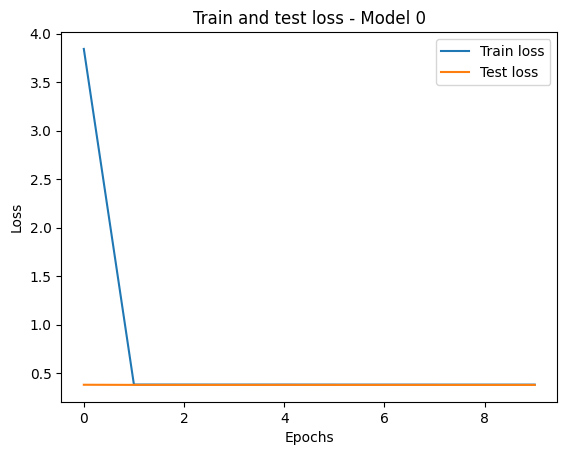

In [56]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(epoch_count_0, np.array(torch.tensor(train_loss_values_0).numpy()), label="Train loss")
plt.plot(epoch_count_0, np.array(torch.tensor(test_loss_values_0).numpy()), label="Test loss")
plt.title("Train and test loss - Model 0")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

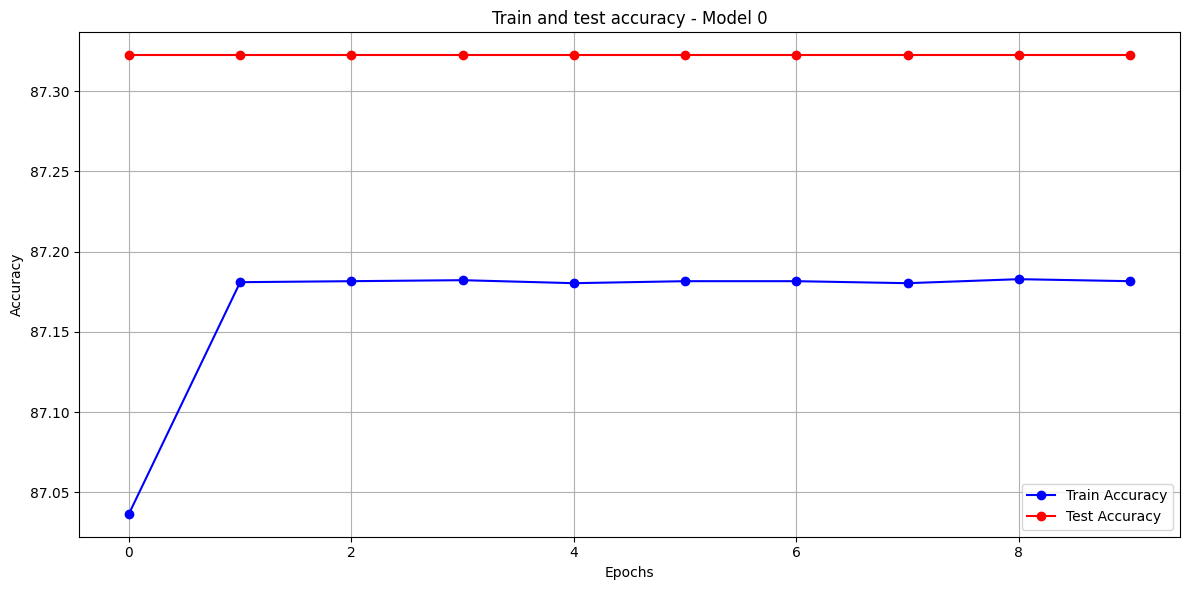

In [57]:
plt.figure(figsize=(12, 6))

plt.plot(epoch_count_0, train_acc_values_0, '-o', label='Train Accuracy', color='blue')
plt.plot(epoch_count_0, test_acc_values_0, '-o', label='Test Accuracy', color='red')

plt.title('Train and test accuracy - Model 0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

AUC for MLP Model 0: 0.5000


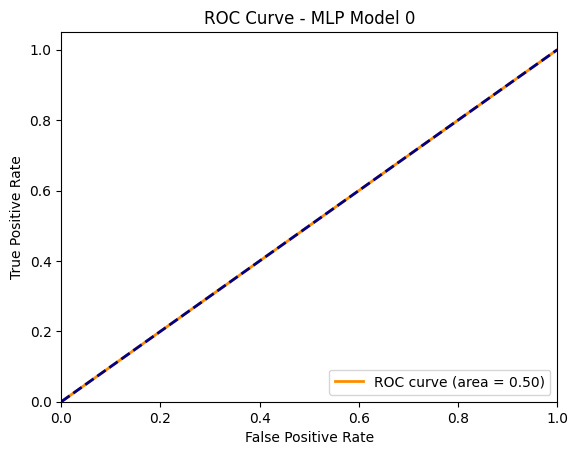

In [58]:
from sklearn.metrics import roc_curve, auc

all_test_probabilities = []
all_true_labels = []

# iterating w test loader
with torch.inference_mode():
    for batch_X, batch_y in test_loader:
        # device agnostic 
        batch_X = batch_X.cuda() if next(model_0.parameters()).is_cuda else batch_X
        batch_y = batch_y.cuda() if next(model_0.parameters()).is_cuda else batch_y
        
        test_logits = model_0(batch_X).squeeze()
        test_probabilities = torch.sigmoid(test_logits).cpu().numpy()
        
        all_test_probabilities.extend(test_probabilities)
        all_true_labels.extend(batch_y.cpu().numpy())

# false positive and true positive rates and thresholds
fpr, tpr, thresholds = roc_curve(all_true_labels, all_test_probabilities)

# calculate auc
roc_auc = auc(fpr, tpr)

# print auc
print(f"AUC for MLP Model 0: {roc_auc:.4f}")

# plot roc and auc
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random classifier diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP Model 0')
plt.legend(loc="lower right")
plt.show()


### Model 1

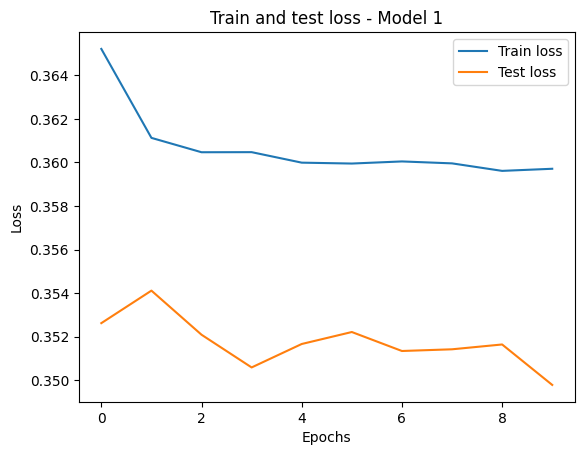

In [59]:
plt.plot(epoch_count_1, np.array(torch.tensor(train_loss_values_1).numpy()), label="Train loss")
plt.plot(epoch_count_1, np.array(torch.tensor(test_loss_values_1).numpy()), label="Test loss")
plt.title("Train and test loss - Model 1")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

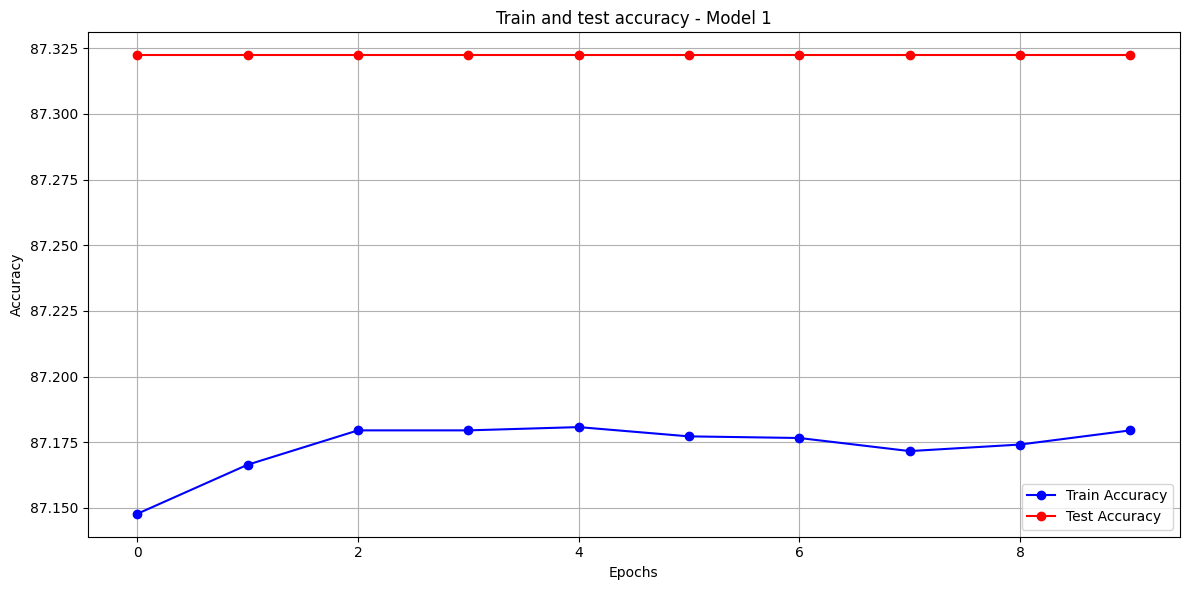

In [60]:
plt.figure(figsize=(12, 6))

plt.plot(epoch_count_1, train_acc_values_1, '-o', label='Train Accuracy', color='blue')
plt.plot(epoch_count_1, test_acc_values_1, '-o', label='Test Accuracy', color='red')

plt.title('Train and test accuracy - Model 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

AUC for MLP Model 1: 0.7070


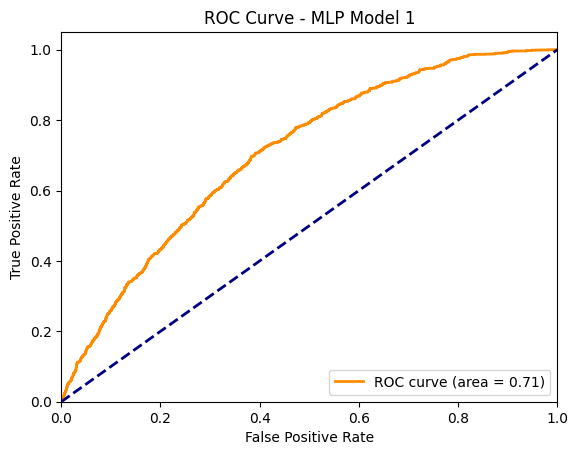

In [61]:
all_test_probabilities = []
all_true_labels = []

# iterating w test loader
with torch.inference_mode():
    for batch_X, batch_y in test_loader:
        # device agnostic 
        batch_X = batch_X.cuda() if next(model_1.parameters()).is_cuda else batch_X
        batch_y = batch_y.cuda() if next(model_1.parameters()).is_cuda else batch_y
        
        test_logits = model_1(batch_X).squeeze()
        test_probabilities = torch.sigmoid(test_logits).cpu().numpy()
        
        all_test_probabilities.extend(test_probabilities)
        all_true_labels.extend(batch_y.cpu().numpy())

# false positive and true positive rates and thresholds
fpr, tpr, thresholds = roc_curve(all_true_labels, all_test_probabilities)

# calculate auc
roc_auc = auc(fpr, tpr)

# print auc
print(f"AUC for MLP Model 1: {roc_auc:.4f}")

# plot roc and auc
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random classifier diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP Model 1')
plt.legend(loc="lower right")
plt.show()


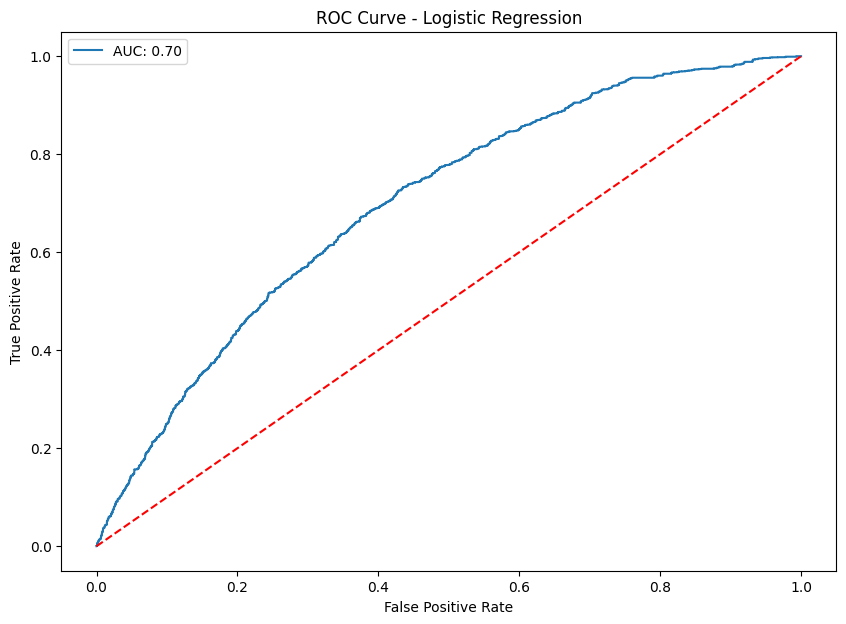

Accuracy: 0.87
AUC: 0.70


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# run logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train.ravel())

# predict probs
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# compute accuracy
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test.ravel(), y_pred)

# compute auc
auc = roc_auc_score(y_test.ravel(), y_pred_prob)

# compute and plot roc curve
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred_prob)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}") 
